In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# from nltk.tokenize import word_tokenize as wt 
# from collections import Counter
# import gensim
# import textblob
import spacy

## **Plan of Action**

- Load the data
- Drop unnecessary columns and rows
- Removal of stop words.
- Feature engineering;
    - BOW
- Begin modelling
    - Algorithms to use;
        - k-Nearest Neighbors.
        - Decision Trees.
        - Naive Bayes.
        - Random Forest.
        - Gradient Boosting.
        - Logistic Regression
- Evaluation;
    - F1-score_macro
    - AUC
    - ROC

In [4]:
df_clean = pd.read_csv('../../cleaned_reviews.csv')
df_clean_spell = pd.read_csv('../../correct_spelling_reviews.csv')

In [7]:
df_clean.shape

(17340, 4)

In [8]:
df_clean_spell.shape

(17340, 4)

In [9]:
df_clean.columns

Index(['sentiments', 'cleaned_review', 'cleaned_review_length',
       'review_score'],
      dtype='object')

In [10]:
df_clean_spell.columns

Index(['sentiments', 'corrected_review', 'corrected_review_length',
       'review_score'],
      dtype='object')

In [11]:
df_clean.drop(columns=['cleaned_review_length','review_score'],inplace=True)
df_clean_spell.drop(columns=['corrected_review_length','review_score'],inplace=True)

Checking for Null Vaules and Duplicates

In [12]:
df_clean.isna().sum()

sentiments        0
cleaned_review    3
dtype: int64

In [13]:
df_clean_spell.isna().sum()

sentiments          0
corrected_review    3
dtype: int64

In [14]:
df_clean.dropna(inplace=True)
df_clean_spell.dropna(inplace=True)

In [15]:
df_clean.shape

(17337, 2)

In [16]:
df_clean_spell.shape

(17337, 2)

In [17]:
from spacy.lang.en.stop_words import STOP_WORDS

# print(STOP_WORDS,'\n') # <- set of Spacy's default stop words
all_stopwords = STOP_WORDS
# Adding several stopwords
# all_stopwords |= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against'}

# Removing several stop words
all_stopwords-= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against','off','against','too'}
my_stop_words = set(all_stopwords) # My own stop words

In [18]:
df_clean

,sentiments,cleaned_review
0,positive,i wish would have gotten one earlier love it a...
1,neutral,i ve learned this lesson again open the packag...
2,neutral,it is so slow and lags find better option
3,neutral,roller ball stopped working within months of m...
4,neutral,i like the color and size but it few days out ...
...,...,...
17335,positive,i love this speaker and love can take it anywh...
17336,positive,i use it in my house easy to connect and loud ...
17337,positive,the bass is good and the battery is amazing mu...
17338,positive,love it


In [19]:
df_clean_spell.head()

,sentiments,corrected_review
0,positive,i wish would have gotten one earlier love it a...
1,neutral,i ve learned this lesson again open the packag...
2,neutral,it is so slow and laws find better option
3,neutral,roller ball stopped working within months of m...
4,neutral,i like the color and size but it few days out ...


In [20]:
nlp = spacy.load("en_core_web_sm")
df_clean['lemma_review'] = df_clean['cleaned_review'].apply(lambda text: 
                         " ".join(token.lemma_ for token in nlp(text) 
                            if token.text not in my_stop_words))
df_clean.head(5)

,sentiments,cleaned_review,lemma_review
0,positive,i wish would have gotten one earlier love it a...,wish get early love make work laptop easy
1,neutral,i ve learned this lesson again open the packag...,ve learn lesson open package use product right...
2,neutral,it is so slow and lags find better option,slow lag find well option
3,neutral,roller ball stopped working within months of m...,roller ball stop work month minimal use piece ...
4,neutral,i like the color and size but it few days out ...,like color size day return period not hold charge


In [21]:
df_clean_spell['lemma_review'] = df_clean_spell['corrected_review'].apply(lambda text: 
                         " ".join(token.lemma_ for token in nlp(text) 
                            if token.text not in my_stop_words))
df_clean_spell.head(5)

,sentiments,corrected_review,lemma_review
0,positive,i wish would have gotten one earlier love it a...,wish get early love make work lawton easy
1,neutral,i ve learned this lesson again open the packag...,ve learn lesson open package use product right...
2,neutral,it is so slow and laws find better option,slow law find well option
3,neutral,roller ball stopped working within months of m...,roller ball stop work month minimal use piece ...
4,neutral,i like the color and size but it few days out ...,like color size day return period not hold charge


In [22]:
# Dropping unnecessary columns

df_clean.drop(columns=['cleaned_review'],inplace=True)
df_clean_spell.drop(columns=['corrected_review'],inplace=True)

Sentiment Mapping

In [23]:
sentiment_mapping = {'negative':-1,'neutral':0,'positive':1}
df_clean['sentiment_label'] = df_clean.sentiments.map(sentiment_mapping)
df_clean_spell['sentiment_label'] = df_clean_spell.sentiments.map(sentiment_mapping)

In [24]:
df_clean.drop(columns=['sentiments'],inplace=True)
df_clean_spell.drop(columns=['sentiments'],inplace=True)

In [25]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_validate, StratifiedShuffleSplit,cross_val_score

# The algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

Approaches;
- Use of Unigrams
- Use of Bigrams
- Use of Trigrams
- Use of combo grams_1 (1,2)
- Use of combo grams_2 (1,3)

## **Using df_clean**

### **Unigrams**

In [22]:
count_vectorizer = CountVectorizer()

In [23]:
X  = count_vectorizer.fit_transform(df_clean.iloc[:,0]).toarray()
y = df_clean.iloc[:,-1]

In [24]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)

In [26]:
models = {
    "DT": DecisionTreeClassifier(max_depth=3),
    "RF": RandomForestClassifier(max_depth=3),
    "GB": GradientBoostingClassifier(max_depth=3),
    "MNB": MultinomialNB(),
    "KNN": KNeighborsClassifier(),
    "LR": LogisticRegression(multi_class='multinomial',solver='lbfgs'),
    "HGB": HistGradientBoostingClassifier(max_depth=3)
}

In [27]:
# https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f
# The abov link explains why f1_macro was used
model_results_f1_macro = []
model_names = []
model_mean = []

In [28]:
my_cv = StratifiedShuffleSplit(n_splits=5,test_size=.1,random_state=42) # 10% for validation 
scoring = 'f1_macro'
for name, model in models.items():
    model_names.append(name) # append each name of the model
    print(model) # print the model name for checks
    cv_results = cross_val_score(model,X_train,y_train,scoring=scoring,cv=my_cv,n_jobs=-2) 
    cv_results_list = cv_results.tolist() # Turning the array to a list
    model_results_f1_macro.append(cv_results_list) # append validation results
    model_mean.append(cv_results.mean()) # append the mean

DecisionTreeClassifier(max_depth=3)
RandomForestClassifier(max_depth=3)
GradientBoostingClassifier()
MultinomialNB()
KNeighborsClassifier()
LogisticRegression(multi_class='multinomial')
HistGradientBoostingClassifier(max_depth=3)


In [29]:
print(model_results_f1_macro)
print(model_names)
print(model_mean)

[[0.48620491085737066, 0.4686544868268232, 0.46756234352289416, 0.49045692866800933, 0.4735086637901514], [0.2359882005899705, 0.2359882005899705, 0.2359882005899705, 0.2359882005899705, 0.2359882005899705], [0.687805157647056, 0.6809060703745468, 0.6887577353379015, 0.6816386213824046, 0.683521162927931], [0.5945069345024744, 0.5956211673328089, 0.5975111893651753, 0.6103829309438606, 0.6182413031831949], [0.5555458654922311, 0.5451378956140861, 0.5722209566107203, 0.565040187756641, 0.5458184354364467], [0.8057714140445932, 0.8102982180877403, 0.806265053952186, 0.8153805353378214, 0.8068170979600056], [0.7035383723381825, 0.6966914625416291, 0.7066045324673335, 0.7166678564087877, 0.7141941608426317]]
['DT', 'RF', 'GB', 'MNB', 'KNN', 'LR', 'HGB']
[0.47727746673304977, 0.2359882005899705, 0.6845257495339679, 0.6032527050655029, 0.556752668182025, 0.8089064638764694, 0.7075392769197129]


In [30]:
# Creating a Dictionary of results
f1score_result_dict = dict(zip(model_names,model_results_f1_macro))
f1score_mean_dict = dict(zip(model_names,model_mean))

In [31]:
# Creating a Dataframe of results
f1score_result_frame = pd.DataFrame(f1score_result_dict)
f1score_mean_frame = pd.Series(f1score_mean_dict).to_frame('mean_f1_score').reset_index()
f1score_mean_frame.rename(columns={'index':'models'},inplace=True)

In [32]:
f1score_result_frame

,DT,RF,GB,MNB,KNN,LR,HGB
0,0.486205,0.235988,0.687805,0.594507,0.555546,0.805771,0.703538
1,0.468654,0.235988,0.680906,0.595621,0.545138,0.810298,0.696691
2,0.467562,0.235988,0.688758,0.597511,0.572221,0.806265,0.706605
3,0.490457,0.235988,0.681639,0.610383,0.565040,0.815381,0.716668
4,0.473509,0.235988,0.683521,0.618241,0.545818,0.806817,0.714194


In [33]:
f1score_result_frame.to_csv("validation_bow/unigram_f1score_bow_results.csv")

In [34]:
f1score_mean_frame.sort_values(by='mean_f1_score',ascending=False)

,models,mean_f1_score
5,LR,0.808906
6,HGB,0.707539
2,GB,0.684526
3,MNB,0.603253
4,KNN,0.556753
0,DT,0.477277
1,RF,0.235988


In [35]:
f1score_mean_frame.to_csv("validation_bow/unigram_f1score_bow_mean_results.csv")

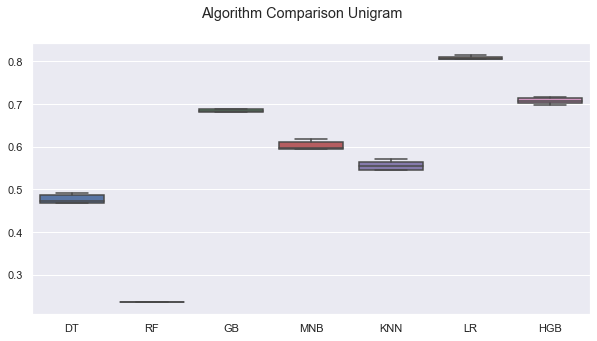

In [36]:
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=f1score_result_frame)
ax.set_xticklabels(model_names)
fig.suptitle('Algorithm Comparison Unigram')
plt.show()

The unigram approach is quite computationally expensive with the training of several algorithms but the top three algorithms are;
1. Logistic Regression
2. HistGradientBoostingClassifier
3. GradientBoostingClassifier

ngrams of (2,2), (3,3), (1,2) and (1,3) will not be used due to memory error, the below error occured due when using (1,3);

**MemoryError: Unable to allocate 25.8 GiB for an array with shape (13869, 249569) and data type int64**

## **Using df_clean_spell**

### **Unigrams**

In [35]:
count_vectorizer = CountVectorizer()

In [36]:
X  = count_vectorizer.fit_transform(df_clean_spell.iloc[:,0]).toarray()
y = df_clean_spell.iloc[:,-1]

In [37]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)

In [38]:
models = {
    "GB": GradientBoostingClassifier(max_depth=3),
    "LR": LogisticRegression(multi_class='multinomial',solver='lbfgs'),
    "HGB": HistGradientBoostingClassifier(max_depth=3)
}

In [39]:
# https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f
# The abov link explains why f1_macro was used
model_results_f1_macro = []
model_names = []
model_mean = []

In [40]:
my_cv = StratifiedShuffleSplit(n_splits=5,test_size=.1,random_state=42) # 10% for validation 
scoring = 'f1_macro'
for name, model in models.items():
    model_names.append(name) # append each name of the model
    print(model) # print the model name for checks
    cv_results = cross_val_score(model,X_train,y_train,scoring=scoring,cv=my_cv,n_jobs=-2) 
    cv_results_list = cv_results.tolist() # Turning the array to a list
    model_results_f1_macro.append(cv_results_list) # append validation results
    model_mean.append(cv_results.mean()) # append the mean

GradientBoostingClassifier()
LogisticRegression(multi_class='multinomial')
HistGradientBoostingClassifier(max_depth=3)


In [41]:
print(model_results_f1_macro)
print(model_names)
print(model_mean)

[[0.6515312956884697, 0.6614352297689883, 0.678715434525832, 0.660059061393496, 0.6802870686727007], [0.7949048372180952, 0.7973287128740605, 0.8009778213593384, 0.7730861244019138, 0.8133852039576572], [0.6868662345577595, 0.6850067578173684, 0.6946723656347774, 0.6528876908697977, 0.7027306505208534]]
['GB', 'LR', 'HGB']
[0.6664056180098974, 0.795936539962213, 0.6844327398801113]


In [42]:
# Creating a Dictionary of results
f1score_result_dict = dict(zip(model_names,model_results_f1_macro))
f1score_mean_dict = dict(zip(model_names,model_mean))

In [43]:
# Creating a Dataframe of results
f1score_result_frame = pd.DataFrame(f1score_result_dict)
f1score_mean_frame = pd.Series(f1score_mean_dict).to_frame('mean_f1_score').reset_index()
f1score_mean_frame.rename(columns={'index':'models'},inplace=True)

In [44]:
f1score_result_frame

,GB,LR,HGB
0,0.651531,0.794905,0.686866
1,0.661435,0.797329,0.685007
2,0.678715,0.800978,0.694672
3,0.660059,0.773086,0.652888
4,0.680287,0.813385,0.702731


In [45]:
f1score_result_frame.to_csv("validation_bow/df_clean_spell_unigram_f1score_bow_results.csv")

In [46]:
f1score_mean_frame.sort_values(by='mean_f1_score',ascending=False)

,models,mean_f1_score
1,LR,0.795937
2,HGB,0.684433
0,GB,0.666406


In [47]:
f1score_mean_frame.to_csv("validation_bow/df_clean_spell_unigram_f1score_bow_mean_results.csv")

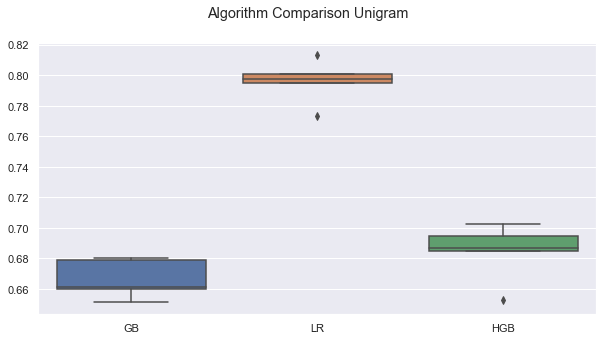

In [48]:
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=f1score_result_frame)
ax.set_xticklabels(model_names)
fig.suptitle('Algorithm Comparison Unigram')
plt.show()

From the two datasets, Logistic Regression has come out as the best classifier based on f1_score_macro

## **Model  Building**

### **df_clean**

Starting with df_clean
- Grid search shall be used to fine tune Logistic Regression
- PCA shall also be used with Logistic Regression to see if the perfomance on the training set; same procedure shall be used for df_clean_spell 

In [22]:
count_vectorizer = CountVectorizer()
X  = count_vectorizer.fit_transform(df_clean.iloc[:,0]).toarray()
y = df_clean.iloc[:,-1]

Text(0.5, 1.0, 'Using PCA for Feature Engineering')

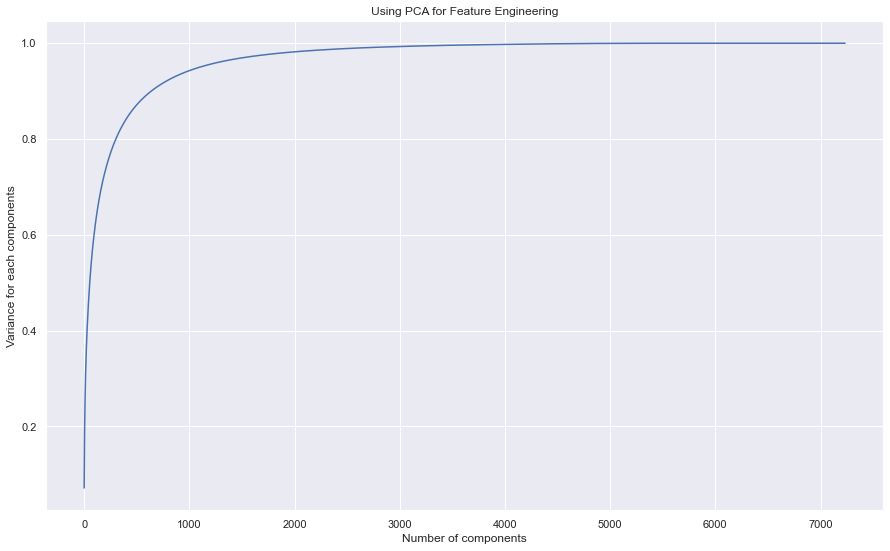

In [23]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)
pca_data = pca.transform(X)

# plotting the cumulative summation of the explained variance
sns.set_theme(style='darkgrid')
fig,ax = plt.subplots(figsize=(15,9))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance for each components')
ax.set_title("Using PCA for Feature Engineering")

In [24]:
exp_var_cumsum = pd.Series(np.round(pca.explained_variance_ratio_.cumsum(),4)*100)

for index,var in enumerate(exp_var_cumsum):
    print(f'If pca components is: {index}    Variance: {np.around(var,3)}')

# 91% Variance reduces the number of components to 700
# This could also be the same for df_clean_spell

If pca components is: 0    Variance: 7.12
If pca components is: 1    Variance: 11.06
If pca components is: 2    Variance: 14.06
If pca components is: 3    Variance: 16.56
If pca components is: 4    Variance: 18.84
If pca components is: 5    Variance: 20.8
If pca components is: 6    Variance: 22.28
If pca components is: 7    Variance: 23.69
If pca components is: 8    Variance: 24.99
If pca components is: 9    Variance: 26.21
If pca components is: 10    Variance: 27.32
If pca components is: 11    Variance: 28.41
If pca components is: 12    Variance: 29.38
If pca components is: 13    Variance: 30.33
If pca components is: 14    Variance: 31.25
If pca components is: 15    Variance: 32.13
If pca components is: 16    Variance: 32.96
If pca components is: 17    Variance: 33.71
If pca components is: 18    Variance: 34.43
If pca components is: 19    Variance: 35.11
If pca components is: 20    Variance: 35.78
If pca components is: 21    Variance: 36.4
If pca components is: 22    Variance: 37.0
If

Two models for df_clean;
- model without pca
- model with pca 

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)

In [28]:
# Without PCA
pipe = Pipeline([('clf',LogisticRegression(multi_class='multinomial',solver='lbfgs'))])

In [30]:
paramter_grid = {'clf__C':[0.0001,0.001,0.1,1,10,100]
                }
my_cv = StratifiedShuffleSplit(n_splits=5,test_size=.1,random_state=42)

In [31]:
mygrid = GridSearchCV(pipe,param_grid=paramter_grid,cv=my_cv,scoring='f1_macro')
mygrid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.1,
            train_size=None),
             estimator=Pipeline(steps=[('clf',
                                        LogisticRegression(multi_class='multinomial'))]),
             param_grid={'clf__C': [0.0001, 0.001, 0.1, 1, 10, 100]},
             scoring='f1_macro')

In [32]:
print(f"Best params: {mygrid.best_params_}\n")
print(f"Best estimator: {mygrid.best_estimator_}\n")
print(f"Best validation score: {mygrid.best_score_}")

Best params: {'clf__C': 10}

Best estimator: Pipeline(steps=[('clf', LogisticRegression(C=10, multi_class='multinomial'))])

Best validation score: 0.8245702756784237


In [33]:
mygrid_trainset = mygrid.best_estimator_
mygrid_trainset

# Pipeline(steps=[('clf', LogisticRegression(C=10, multi_class='multinomial'))])
# Best validation score: 0.8245702756784237

Pipeline(steps=[('clf', LogisticRegression(C=10, multi_class='multinomial'))])

              precision    recall  f1-score   support

          -1       0.98      0.93      0.95      1227
           0       0.95      0.97      0.96      5040
           1       0.98      0.98      0.98      7602

    accuracy                           0.97     13869
   macro avg       0.97      0.96      0.96     13869
weighted avg       0.97      0.97      0.97     13869



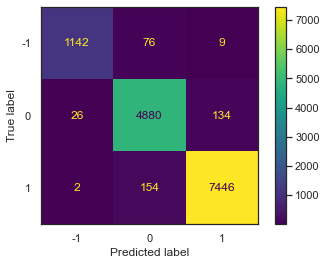

In [34]:
# Classification report
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_pred_train = mygrid_trainset.predict(X_train)



y_train = y_train
sns.set_theme(style='white')
def class_report(model,y_train,y_pred_train):
    print(classification_report(y_train,y_pred_train))
    cm = confusion_matrix(y_train,y_pred_train,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()


class_report(mygrid_trainset,y_train,y_pred_train)

In [44]:
# With PCA
pipe = Pipeline([('pca',PCA(.91)),
('clf',LogisticRegression(multi_class='multinomial',solver='lbfgs'))])

In [45]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)

In [46]:
paramter_grid = {'clf__C':[0.0001,0.001,0.1,1,10,100]
                }
my_cv = StratifiedShuffleSplit(n_splits=5,test_size=.1,random_state=42)

In [47]:
mygrid = GridSearchCV(pipe,param_grid=paramter_grid,cv=my_cv,scoring='f1_macro')
mygrid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.1,
            train_size=None),
             estimator=Pipeline(steps=[('pca', PCA(n_components=0.91)),
                                       ('clf',
                                        LogisticRegression(multi_class='multinomial'))]),
             param_grid={'clf__C': [0.0001, 0.001, 0.1, 1, 10, 100]},
             scoring='f1_macro')

In [48]:
print(f"Best params: {mygrid.best_params_}\n")
print(f"Best estimator: {mygrid.best_estimator_}\n")
print(f"Best validation score: {mygrid.best_score_}")

Best params: {'clf__C': 10}

Best estimator: Pipeline(steps=[('pca', PCA(n_components=0.91)),
                ('clf', LogisticRegression(C=10, multi_class='multinomial'))])

Best validation score: 0.7696432333619108


In [49]:
mygrid_trainset = mygrid.best_estimator_
mygrid_trainset

# Best validation score: 0.7696432333619108
# Pipeline(steps=[('pca', PCA(n_components=0.91)),
                # ('clf', LogisticRegression(C=10, multi_class='multinomial'))])

Pipeline(steps=[('pca', PCA(n_components=0.91)),
                ('clf', LogisticRegression(C=10, multi_class='multinomial'))])

              precision    recall  f1-score   support

          -1       0.83      0.68      0.75      1227
           0       0.84      0.88      0.86      5040
           1       0.93      0.93      0.93      7602

    accuracy                           0.89     13869
   macro avg       0.87      0.83      0.85     13869
weighted avg       0.89      0.89      0.89     13869



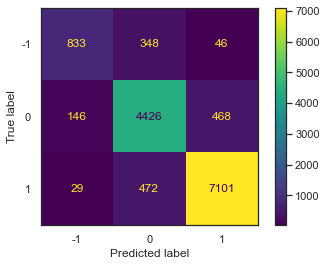

In [50]:
# Classification report
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_pred_train = mygrid_trainset.predict(X_train)



y_train = y_train
sns.set_theme(style='white')
def class_report(model,y_train,y_pred_train):
    print(classification_report(y_train,y_pred_train))
    cm = confusion_matrix(y_train,y_pred_train,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()


class_report(mygrid_trainset,y_train,y_pred_train)

In [54]:
from sklearn.multiclass import  OneVsRestClassifier
from sklearn.preprocessing import  label_binarize
from sklearn.metrics import roc_curve,roc_auc_score,auc
# Reference: https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier
from sklearn.preprocessing import label_binarize

In [74]:
count_vectorizer = CountVectorizer()
X  = count_vectorizer.fit_transform(df_clean.iloc[:,0]).toarray()
y = df_clean.iloc[:,-1]

In [75]:
y = label_binarize(y, classes=[-1,0,1])
n_classes = y.shape[1]

X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)


# Without PCA
pipe = Pipeline([('clf',OneVsRestClassifier(LogisticRegression(multi_class='multinomial',solver='lbfgs',C=10)))])

# With PCA
# pipe = Pipeline([('pca',PCA(.91)),
# ('clf',OneVsRestClassifier(LogisticRegression(multi_class='multinomial',solver='lbfgs',C=10)))])


pipe.fit(X_train, y_train)
X_train = X_train.astype(int)
y_prediction_proba = pipe.predict_proba(X_train) 

In [76]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

def roc_curve_plot(value,y_train):
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_train[:,i], value[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i],lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
             
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve of multiclass; dataset")
    plt.show()
    roc_auc_scoring_macro_ovr = roc_auc_score(y_train,value, multi_class="OvR",average='macro')
    print("AUC score using OvR, macro-averaged over all classes: {:.3f}"
    .format(roc_auc_scoring_macro_ovr))

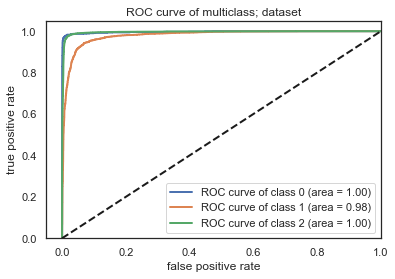

AUC score using OvR, macro-averaged over all classes: 0.990


In [77]:
roc_curve_plot(y_prediction_proba,y_train)
# with PCA: AUC score using OvR, macro-averaged over all classes: 0.950
# Without PCA: AUC score using OvR, macro-averaged over all classes: 0.990

Observations from Confusion matrix and ROC plots;
- It's safe to say that without PCA is better than with PCA
- The f1_score_macro with PCA is 0.85 while without PCA is 0.96; 0.11 better

Building the model with best estimator and testing on test data

In [82]:
count_vectorizer = CountVectorizer()
X  = count_vectorizer.fit_transform(df_clean.iloc[:,0]).toarray()
y = df_clean.iloc[:,-1]

In [83]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)

In [84]:
clf = LogisticRegression(C=10, multi_class='multinomial',solver='lbfgs')
clf.fit(X_train,y_train)

LogisticRegression(C=10, multi_class='multinomial')

**Test data**

              precision    recall  f1-score   support

          -1       0.71      0.65      0.68       307
           0       0.84      0.86      0.85      1260
           1       0.93      0.93      0.93      1901

    accuracy                           0.88      3468
   macro avg       0.83      0.81      0.82      3468
weighted avg       0.88      0.88      0.88      3468



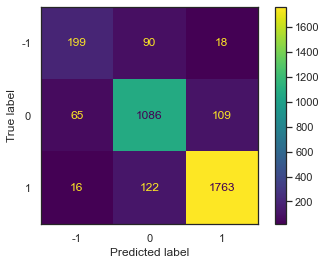

In [85]:
# Classification report test data
y_test = y_test
y_pred_test = clf.predict(X_test)
sns.set_theme(style='white')
def class_report(model,y_test,pred):
    print(classification_report(y_test,pred))
    cm = confusion_matrix(y_test,pred,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()


class_report(clf,y_test,y_pred_test)

**ROC on test data**

In [88]:
count_vectorizer = CountVectorizer()
X  = count_vectorizer.fit_transform(df_clean.iloc[:,0]).toarray()
y = df_clean.iloc[:,-1]

In [90]:
y = label_binarize(y, classes=[-1,0,1])
n_classes = y.shape[1]

X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)


clf = OneVsRestClassifier(LogisticRegression(C=10, multi_class='multinomial',solver='lbfgs'))
clf.fit(X_train,y_train)

X_test = X_test.astype(int)
y_prediction_proba = clf.predict_proba(X_test) 

In [91]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

def roc_curve_plot_test(value,y_test):
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], value[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i],lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
             
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve of multiclass; dataset")
    plt.show()
    roc_auc_scoring_macro_ovr = roc_auc_score(y_test,value, multi_class="OvR",average='macro')
    print("AUC score using OvR, macro-averaged over all classes: {:.3f}"
    .format(roc_auc_scoring_macro_ovr))

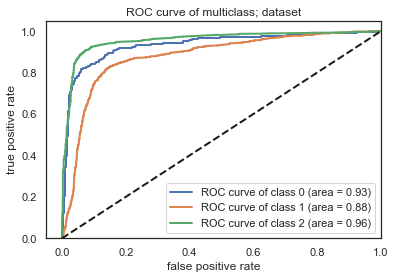

AUC score using OvR, macro-averaged over all classes: 0.923


In [92]:
roc_curve_plot_test(y_prediction_proba,y_test)
# Test data ROC: AUC score using OvR, macro-averaged over all classes: 0.923

### **Using df_clean_spell**

Making use of the model without PCA approach for this data set as the previous one has shown better performance compared to that with PCA.

In [101]:
count_vectorizer = CountVectorizer()
X  = count_vectorizer.fit_transform(df_clean_spell.iloc[:,0]).toarray()
y = df_clean_spell.iloc[:,-1]

In [102]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)

In [103]:
clf = LogisticRegression(multi_class='multinomial',solver='lbfgs', C=10)
clf.fit(X_train,y_train)

LogisticRegression(C=10, multi_class='multinomial')

              precision    recall  f1-score   support

          -1       0.96      0.93      0.94      1192
           0       0.95      0.96      0.96      5022
           1       0.98      0.98      0.98      7655

    accuracy                           0.97     13869
   macro avg       0.96      0.96      0.96     13869
weighted avg       0.97      0.97      0.97     13869



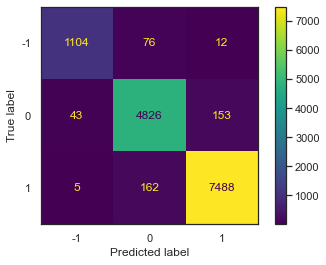

In [104]:
# Classification report
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_pred_train = clf.predict(X_train)
y_train = y_train
class_report(clf,y_train,y_pred_train)

**ROC train**

In [105]:
y = label_binarize(y, classes=[-1,0,1])
n_classes = y.shape[1]

X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)


clf = OneVsRestClassifier(LogisticRegression(multi_class='multinomial',solver='lbfgs', C=10))
clf.fit(X_train,y_train)


X_train = X_train.astype(int)
y_prediction_proba = clf.predict_proba(X_train) 

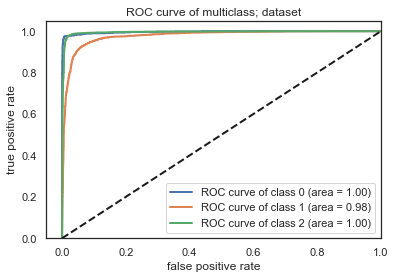

AUC score using OvR, macro-averaged over all classes: 0.989


In [106]:
roc_curve_plot(y_prediction_proba,y_train)

- The AUC score using OvR, macro-averaged over all classes is 0.989
- This is lower than the dataset without spelling correction; 0.990

Building the model with best estimator and testing on test data

In [107]:
count_vectorizer = CountVectorizer()
X  = count_vectorizer.fit_transform(df_clean_spell.iloc[:,0]).toarray()
y = df_clean_spell.iloc[:,-1]

In [108]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)

In [109]:
clf = LogisticRegression(C=10, multi_class='multinomial',solver='lbfgs')
clf.fit(X_train,y_train)

LogisticRegression(C=10, multi_class='multinomial')

**Test data**

              precision    recall  f1-score   support

          -1       0.72      0.64      0.68       298
           0       0.82      0.84      0.83      1256
           1       0.92      0.93      0.93      1914

    accuracy                           0.87      3468
   macro avg       0.82      0.80      0.81      3468
weighted avg       0.87      0.87      0.87      3468



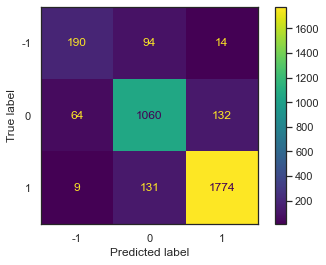

In [111]:
# Classification report test data
y_test = y_test
y_pred_test = clf.predict(X_test)
class_report(clf,y_test,y_pred_test)

### Note that this has more data points than the previous model

**ROC on test data**

In [112]:
count_vectorizer = CountVectorizer()
X  = count_vectorizer.fit_transform(df_clean_spell.iloc[:,0]).toarray()
y = df_clean_spell.iloc[:,-1]

In [113]:
y = label_binarize(y, classes=[-1,0,1])
n_classes = y.shape[1]

X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)


clf = OneVsRestClassifier(LogisticRegression(C=10, multi_class='multinomial',solver='lbfgs'))
clf.fit(X_train,y_train)

X_test = X_test.astype(int)
y_prediction_proba = clf.predict_proba(X_test) 

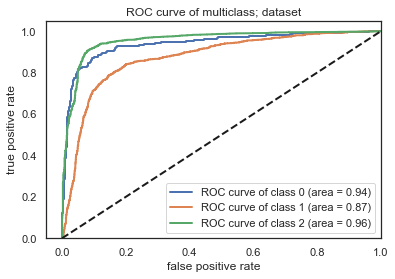

AUC score using OvR, macro-averaged over all classes: 0.922


In [114]:
roc_curve_plot_test(y_prediction_proba,y_test)

- The AUC score using OvR, macro-averaged over all classes is 0.922
- This is lower than the dataset without spelling correction; 0.923

## **Conclusion**

Both approaches are good, with the slight difference in performance when using the following;
dataset|f1_score_macro_avg|AUC_score_avg
| ----------- | ----------- | ----------- |
df_clean_(train data)|0.96|0.990
df_clean_spell(train)|0.96|0.989
df_clean (test data)|0.82|0.923
df_clean_spell(test)|0.81|0.922



Although this shows good performance, it will fail at predicting fresh new data when passed into it. For example, if the feature space of a prediction dataset is 11 (lower than the required features which 7000 above), then the prediction will not work and if we retrain the model to require on a feature space of 11; *CountVectorizer(max_features=11)* then the model will make **WRONG PREDICTIONS** 

Hence TF-IDF can be skipped as the same problem will definitely be encountered because as **the feature vectors are sparse and high-dimensional representations. The dimensionality increases with the size of the vocabulary, with most values being zero for any vector.** *(Practical Natural Language Processing A Comprehensive Guide to Building Real-World NLP Systems by Sowmya Vajjala, Bodhisattwa Majumder, Anuj Gupta, and Harshit Surana)*